In [1]:
import tensorflow as tf
import numpy as np
# import pandas as pd
import glob
import matplotlib.pyplot as plt
# import seaborn as sns
# from resizeimage import resizeimage
%matplotlib inline
# tf.logging.set_verbosity(tf.logging.INFO)

/Users/jeromekafrouni/.pyenv/versions/3.6.1/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
ls ../data

README.md  pets.zip         pets_neuralnet_original/     zipcode/
__MACOSX/  pets_neuralnet/  pets_neuralnet_original.zip


# Neural net v2: using ImageDataGenerator to load and preprocess

## Prepare folder for train/test sets, in keras format

In [4]:
import os
import shutil

In [5]:
ls ../data

README.md  pets.zip         pets_neuralnet_original/     zipcode/
__MACOSX/  pets_neuralnet/  pets_neuralnet_original.zip


In [8]:
original_dataset_dir = '../data/pets_neuralnet_original'

In [6]:
base_dir = '../data/pets_neuralnet'
# os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')
# os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
# os.mkdir(validation_dir)

train_cats_dir = os.path.join(train_dir, 'cats')
# os.mkdir(train_cats_dir)

train_dogs_dir = os.path.join(train_dir, 'dogs')
# os.mkdir(train_dogs_dir)

validation_cats_dir = os.path.join(validation_dir, 'cats')
# os.mkdir(validation_cats_dir)

validation_dogs_dir = os.path.join(validation_dir, 'dogs')
# os.mkdir(validation_dogs_dir)

In [7]:
# cats_filenames = [file for file in glob.glob(original_dataset_dir + '/cat/*')]

In [8]:
# dogs_filenames = [file for file in glob.glob(original_dataset_dir + '/dog/*')]

In [9]:
# for fname in cats_filenames[:521]: # 80 % split
#     name = fname.split('/')[-1]
#     shutil.copyfile(fname, os.path.join(train_cats_dir, name))
    
# for fname in cats_filenames[521:]: # 80 % split
#     name = fname.split('/')[-1]
#     shutil.copyfile(fname, os.path.join(validation_cats_dir, name))
    
# for fname in dogs_filenames[:1078]: # 80 % split
#     name = fname.split('/')[-1]
#     shutil.copyfile(fname, os.path.join(train_dogs_dir, name))
    
# for fname in dogs_filenames[1078:]: # 80 % split
#     name = fname.split('/')[-1]
#     shutil.copyfile(fname, os.path.join(validation_dogs_dir, name))

In [10]:
# from shutil import copyfile
# !mkdir ../data/pets_neuralnet
# !mkdir ../data/pets_neuralnet/cat
# !mkdir ../data/pets_neuralnet/dog

In [11]:
# train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
eval_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [12]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=40,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,)

In [13]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(64, 64),
        batch_size=128,
        class_mode='binary')

Found 1599 images belonging to 2 classes.


In [14]:
eval_generator = eval_datagen.flow_from_directory(
        validation_dir,
        target_size=(64, 64),
        batch_size=32,
        class_mode='binary')

Found 401 images belonging to 2 classes.


Visualize the data augmentation:

In [ ]:
itr = 0
for data_batch, labels_batch in train_generator:
    itr += 1
    plt.imshow(data_batch[0])
    plt.show()
    if itr > 5:
        break

Define model:

We use a classic CNN architecture with 3 convolution layers and one dense layer. There is one dropout layer before the dense layer to avoid overfitting. The activation used is simply "relu", leakyrelu might lead to better results but is not available in Keras.

In [29]:
layers = tf.keras.layers
models = tf.keras.models

model = models.Sequential()
# model.add(layers.Reshape((113, 113, 3), input_shape=(38307,)))
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64, 64, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5)) # this is the "keep prob"
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Adam and RMSProp give good results and converge quite fast.

In [30]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [56]:
# model.fit(X_train, y_train, batch_size=128, epochs=10)

In [31]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=20,
      validation_data=eval_generator,
      validation_steps=50)

Epoch 1/20
100/100 [==============================]100/100 [==============================] - 74s 736ms/step - loss: 0.6091 - acc: 0.6777 - val_loss: 0.5653 - val_acc: 0.6791

Epoch 2/20
100/100 [==============================]100/100 [==============================] - 73s 728ms/step - loss: 0.5822 - acc: 0.6969 - val_loss: 0.5571 - val_acc: 0.6772

Epoch 3/20
100/100 [==============================]100/100 [==============================] - 73s 726ms/step - loss: 0.5490 - acc: 0.7216 - val_loss: 0.5203 - val_acc: 0.7338

Epoch 4/20
100/100 [==============================]100/100 [==============================] - 66s 663ms/step - loss: 0.5280 - acc: 0.7335 - val_loss: 0.4701 - val_acc: 0.7749

Epoch 5/20
100/100 [==============================]100/100 [==============================] - 73s 728ms/step - loss: 0.4852 - acc: 0.7632 - val_loss: 0.5650 - val_acc: 0.7344

Epoch 6/20
100/100 [==============================]100/100 [==============================] - 73s 733ms/step - loss: 0.4

Results:
- 75 % val acc without augmentation (got to 75 % then lower because of overfitting)
- around 89% with data augmentation and images of size 150x150
- around 86% with data augmentation and images of size 64x64 with less epochs

## Visualize results

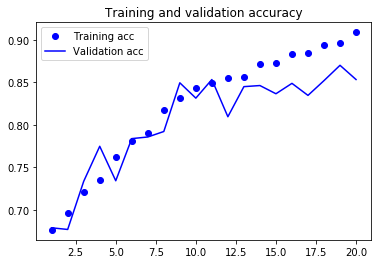

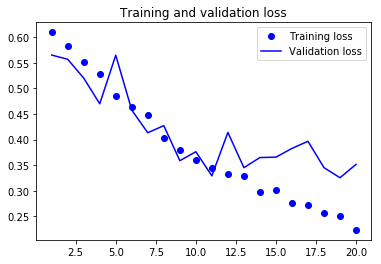

In [32]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Refinement: dealing with class imbalance

Our training data is imbalanced, therefore we can tune Keras to add weights to each class. Since we have 2.08 more cat samples than dog sample, in the fit function we need to assign a weight of 2.08 to cat samples. This is simply done by passing the weights to fit_generator:

## Train model and save it

We can notice that the model overfits after around 12 epochs. Therefore we train again the same model but this time stopping at 12 epochs. (uncomment the following two cells).

In [2]:
# model.compile(optimizer=tf.keras.optimizers.Adam(),
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

In [3]:
# history = model.fit_generator(
#       train_generator,
#       steps_per_epoch=100,
#       epochs=20,
#       validation_data=eval_generator,
#       validation_steps=50,
#       class_weight={0: 2.08, 1: 1.0})

We get a similar plot as the one above, except this time even though the accuracy seems to be the same, the precision and recall are way better on both classes, in other terms the neural net does as well on dogs as on cats.

In [2]:
import h5py

In [34]:
model.save('../cats_and_dogs_v2.h5')

### Load trained model

**Important note**: the code above has been ran on a gcloud instance with GPU, which speeds up exponentially the training. To only reproduce the prediction part, you can load the already trained model which is in a .h5 file in the output/ folder:

In [4]:
model = tf.keras.models.load_model("../output/cats_and_dogs_v3.h5")

Instructions for updating:
keep_dims is deprecated, use keepdims instead


The test folder needs to contain the images **in a subfolder**, due to keras way to dealing with input data.

In [5]:
test_dir = "../test_practice"

In [6]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [7]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(64, 64),
        batch_size=16,
        class_mode=None,  # only data, no labels
        shuffle=False)  # keep data in same order as labels

Found 1860 images belonging to 1 classes.


In [8]:
predictions = model.predict_generator(test_generator)

The list above is a list of probabilities that we convert into actual predictions:

In [9]:
predictions = [0 if pr < 0.5 else 1 for pr in predictions]

**We save the predictions in a file:**

Keras learned classes as 0="cat" and 1="dog".

In [10]:
with open("../output/predictions.txt","w") as file: 
    for predicted_class in predictions:
        if predicted_class == 0:
            file.write("cat\n")
        else:
            file.write("dog\n")